# Predictive Assets Maintenance with BigDL Time Series Toolkit

In this notebook we demonstrate how to use `TCNForecaster` and `ThresholdDetector` to make predictions, anomaly detections and therefore assets maintenance.

For demonstration, we use the publicly available elevator predictive maintenance dataset. You can find the dataset introduction <a href="https://www.kaggle.com/datasets/shivamb/elevator-predictive-maintenance-dataset" target="_blank">here</a>. The target is to predict an absolute value of vibration. Then maintenance teams can be alerted to inspect and address potential issues proactively.

Before runnning the notebook, you need to download the <a href="https://www.kaggle.com/datasets/shivamb/elevator-predictive-maintenance-dataset" target="_blank">dataset</a> from kaggle and decompress it to get a csv file called `predictive-maintenance-dataset.csv`.

## Helper function

This section provides a helper function to plot the ground truth, prediction and anomaly value. You can refer to it later when in use.

In [1]:
def plot_anomalies_value(y_true, y_pred, pattern_ano_index, trend_ano_index, threshold):
    """
    Plot the ground truth, prediction and anomaly value.
    """
    df = pd.DataFrame({"y_true": y_true.squeeze(), "y_pred": y_pred.squeeze()})
    df['p_ano_index'] = 0
    df.loc[df.index[pattern_ano_index], 'ano_index'] = 1
    df['t_ano_index'] = 0
    df.loc[df.index[trend_ano_index], 'ano_index'] = 1
    df['threshold'] = threshold

    fig, axs = plt.subplots(figsize=(16,6))
    axs.plot(df.index, df.y_true, color='blue', label='Ground Truth')
    axs.plot(df.index, df.y_pred, color='orange', label='Prediction')
    axs.plot(df.index, df.threshold, color='black', label='Threshold')
    axs.scatter(df.index[pattern_ano_index].tolist(), df.y_true[pattern_ano_index], color='red', label='checking points for pattern anomaly')
    axs.scatter(df.index[trend_ano_index].tolist(), df.y_true[trend_ano_index], color='green', label='checking points for trend anomaly')
    axs.set_title('Checking Points For Maintenance')
    
    plt.xlabel('time_step')
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Download the <a href="https://www.kaggle.com/datasets/shivamb/elevator-predictive-maintenance-dataset" target="_blank">dataset</a> from kaggle and decompress it to get a csv file called `predictive-maintenance-dataset.csv`. Use pandas to load `predictive-maintenance-dataset.csv` into a dataframe as shown below.

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/dataset/predictive-maintenance-dataset.csv")

Below are some example records of the data

In [4]:
df.head()

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5
0,1,93.744,73.999,18.0,167.743,19.745,1.266828,8787.937536,5475.852001
1,2,93.740,73.999,18.0,167.739,19.741,1.266774,8787.187600,5475.852001
2,3,93.736,73.998,18.0,167.734,19.738,1.266737,8786.437696,5475.704004
3,4,93.732,73.998,18.0,167.730,19.734,1.266683,8785.687824,5475.704004
4,5,93.729,73.998,18.0,167.727,19.731,1.266642,8785.125441,5475.704004


<Axes: title={'center': 'vibration'}, xlabel='ID'>

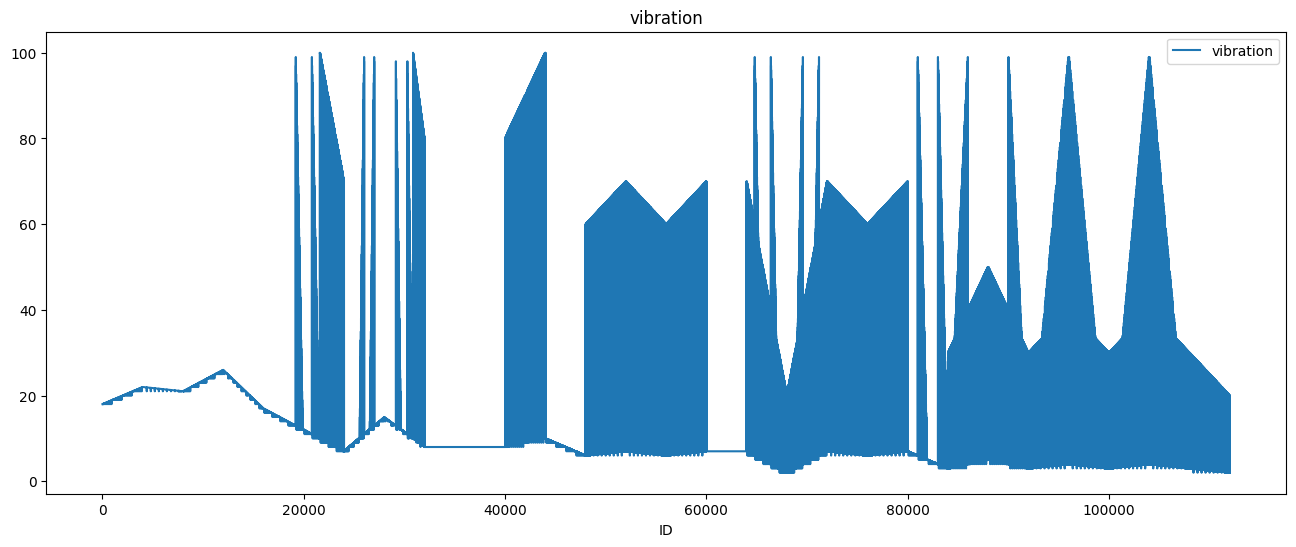

In [5]:
df.plot(y="vibration", x="ID", figsize=(16,6), title="vibration")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part and the following part could vary for different datasets. 

For the elevator data, the pre-processing converts the time step to timestamp starting from 2023-01-01 16:30:00.

In [6]:
df["time_step"] = pd.date_range(start='2023-01-01 16:30:00', end='2023-01-01 23:30:00', periods=len(df))
df

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5,time_step
0,1,93.744,73.999,18.00,167.743,19.745,1.266828,8787.937536,5475.852001,2023-01-01 16:30:00.000
1,2,93.740,73.999,18.00,167.739,19.741,1.266774,8787.187600,5475.852001,2023-01-01 16:30:00.225
2,3,93.736,73.998,18.00,167.734,19.738,1.266737,8786.437696,5475.704004,2023-01-01 16:30:00.450
3,4,93.732,73.998,18.00,167.730,19.734,1.266683,8785.687824,5475.704004,2023-01-01 16:30:00.675
4,5,93.729,73.998,18.00,167.727,19.731,1.266642,8785.125441,5475.704004,2023-01-01 16:30:00.900
...,...,...,...,...,...,...,...,...,...,...
111996,111997,20.186,73.992,2.00,94.178,-53.806,0.272813,407.474596,5474.816064,2023-01-01 23:29:59.100
111997,111998,20.186,73.992,20.01,94.178,-53.806,0.272813,407.474596,5474.816064,2023-01-01 23:29:59.325
111998,111999,20.185,73.992,20.01,94.177,-53.807,0.272800,407.434225,5474.816064,2023-01-01 23:29:59.550
111999,112000,20.185,73.992,20.00,94.177,-53.807,0.272800,407.434225,5474.816064,2023-01-01 23:29:59.775


## Feature Engineering & Data Preperation

We scale and roll the data to generate the sample in numpy ndarray for `TCNForecaster` to use.

We use <a href="https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html" target="_blank">TSDataset</a> to complete the whole processing.

In [7]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

lookback = 120
horizon = 1

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="time_step", target_col="vibration",
                                                              extra_feature_col=["revolutions","humidity","x1","x2","x3","x4","x5"],
                                                              with_split=True, test_ratio=0.1)
standard_scaler = StandardScaler()

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.scale(standard_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=lookback, horizon=horizon)

x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((58041, 120, 8), (58041, 1, 1), (7519, 120, 8), (7519, 1, 1))

## Time series forecasting

First, we initialize a TCNForecaster based on time step and feature number. More information about TCNForecaster can be found <a href="https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html#tcnforecaster" target="_blank">here</a>.

In some industrial scenarios, such as this one, the adverse effect caused by a predicted value being less than the real value is far greater than that caused by a predicted value being greater than the real value. Therefore, in this case, we use a built-in loss function `AsymWeightLoss` to penalize underestimation.

In [8]:
from bigdl.chronos.forecaster import TCNForecaster
from bigdl.chronos.pytorch.loss import AsymWeightLoss

In [9]:
forecaster = TCNForecaster(past_seq_len=lookback,
                           future_seq_len=horizon,
                           input_feature_num=8,
                           output_feature_num=1,
                           normalization=False,
                           kernel_size=5,
                           num_channels=[16]*8,
                           loss=AsymWeightLoss(underestimation_penalty=10))

INFO:pytorch_lightning.utilities.seed:Global seed set to 1368219741
INFO:pytorch_lightning.utilities.seed:Global seed set to 1368219741


Now we train the model and wait until it's finished.

In [10]:
print('Start training ...')
forecaster.num_processes = 1
forecaster.fit(data=tsdata_train, epochs=5)
print('Training completed')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | TemporalConvNet | 21.0 K
1 | loss  | AsymWeightLoss  | 0     
------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)


Start training ...


Training: 0it [00:00, ?it/s]

Training completed


Then we can use the fitted forecaster for prediction and inverse the scaling of the prediction results.

In [11]:
y_pred_train = forecaster.predict(x_train)
y_pred_test = forecaster.predict(x_test)

In [12]:
y_pred_train_unscale = tsdata_train.unscale_numpy(y_pred_train)
y_pred_test_unscale = tsdata_test.unscale_numpy(y_pred_test)
y_train_unscale = tsdata_train.unscale_numpy(y_train)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

In [13]:
from bigdl.chronos.metric.forecast_metrics import Evaluator
metric = Evaluator.evaluate('mse', y_test_unscale, y_pred_test_unscale)
print(f"MSE is {'%.2f' % metric[0]}")

MSE is 20.74


## Checking points detection

Then we initiate a ThresholdDetector to detect checking points, i.e. anomaly needed to pay attention. More information about ThresholdDetector can be found <a href="https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/anomaly_detectors.html#thresholddetector" target="_blank">here</a>. Based on the trainning dataset, we can train it to obtain some information about a threshold.

Moreover, in this case, we can set the absolute threshold of vibration and detect potential elevator failure.

In [14]:
import math
from bigdl.chronos.detector.anomaly import ThresholdDetector
thd = ThresholdDetector()
vibration_th = 85
thd.set_params(trend_threshold=(0, vibration_th)) # if vibration>85, we think there may exist potential elevator failure
thd.fit(y_train_unscale, y_pred_train_unscale)

We detect two types of anomalies, i.e. pattern anomaly and trend anomaly. By comparing real data and predicted data, we find those pattern anomalies. Meanwhile, we also support forecasting anomaly, which is a detected trend anomaly of predicted data.

**Case1**: If we only have predicted data and want to forecast an anomaly

In [15]:
test_anomaly_indexes = thd.anomaly_indexes(y_pred=y_pred_test_unscale)
print("The index of anoalies in test dataset only according to predict data is:")
for key, value in test_anomaly_indexes.items():
    print(f'{key}: {value}')

The index of anoalies in test dataset only according to predict data is:
pattern anomaly index: []
trend anomaly index: [2439, 3079, 3719, 2959, 2839, 3095, 3479, 3359, 2599, 3239, 3495, 3879, 2479, 3119, 3759, 2999, 3639, 3319, 2879, 2759, 3399, 2639, 3279, 3159, 2519, 3799, 3039, 3679, 2919, 3559, 3439, 3839, 2679, 2559]
anomaly index: [3719, 3079, 2439, 2959, 3479, 3095, 2839, 3359, 2599, 3239, 3495, 3879, 2679, 2479, 3119, 3759, 3639, 2999, 2879, 2759, 3399, 2559, 2639, 3279, 3159, 2519, 3799, 3039, 3679, 2919, 3559, 3439, 3319, 3839]


Use `plot_anomalies_value` to intuitively see the detection results.

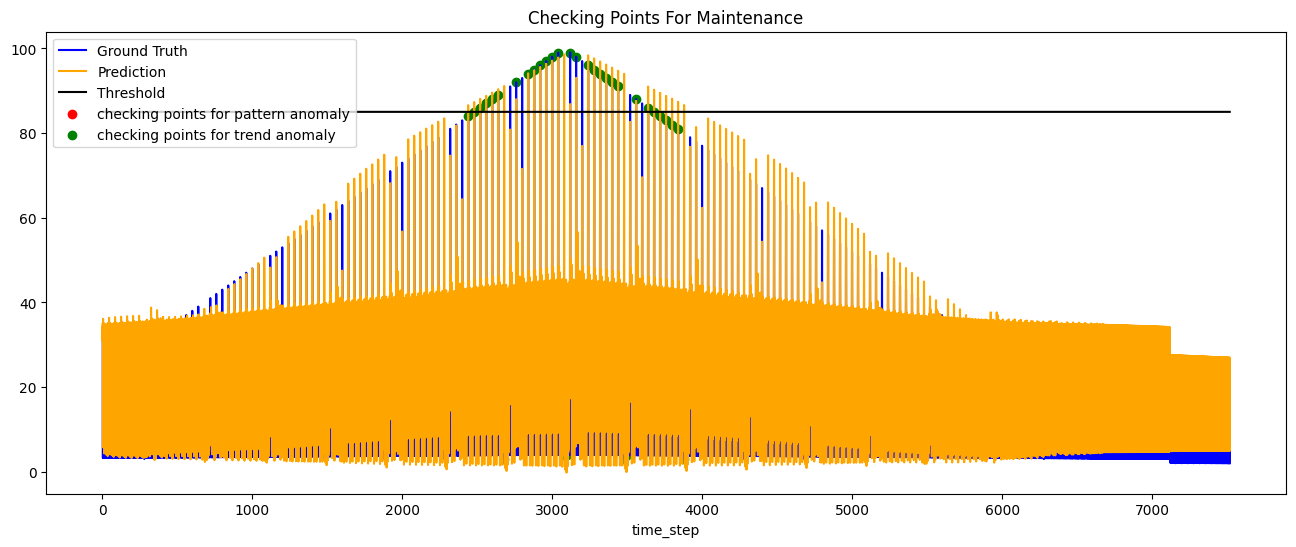

In [16]:
plot_anomalies_value(y_test_unscale, y_pred_test_unscale, test_anomaly_indexes['pattern anomaly index'], test_anomaly_indexes['trend anomaly index'], vibration_th)

**Case2**: If we have true data, predicted data and want to detect an anomaly

In [17]:
test_anomaly_indexes = thd.anomaly_indexes(y=y_test_unscale, y_pred=y_pred_test_unscale)
print("The index of anoalies in test dataset according to true data and predicted data is:")
for key, value in test_anomaly_indexes.items():
    print(f'{key}: {value}')

The index of anoalies in test dataset according to true data and predicted data is:
pattern anomaly index: [279, 679, 1079, 1479, 1879, 1927, 1999, 2279, 2327, 2399, 2679, 2723, 2727, 2799, 3079, 3123, 3127, 3169, 3199, 3479, 3523, 3527, 3599, 3879, 3927, 4279, 4679, 5079, 5479, 5879]
trend anomaly index: [2959, 3599, 2839, 2719, 3359, 2599, 3239, 3119, 2999, 3639, 2879, 3519, 2759, 3399, 2639, 3279, 3159, 2519, 3039, 3199, 2919, 3559, 2799, 3439, 3319, 2559]
anomaly index: [1927, 3079, 5879, 3599, 2959, 2327, 279, 3479, 2839, 2719, 3359, 2723, 679, 2727, 3879, 2599, 3239, 3119, 3123, 3127, 1079, 4279, 2999, 3639, 3319, 2879, 3519, 3523, 1479, 3527, 4679, 2759, 3399, 2559, 1999, 2639, 3279, 1879, 3927, 5079, 3159, 2519, 2399, 3039, 3169, 2279, 5479, 2919, 3559, 2799, 3439, 2679, 3199]


Use `plot_anomalies_value` to intuitively see the detection results.

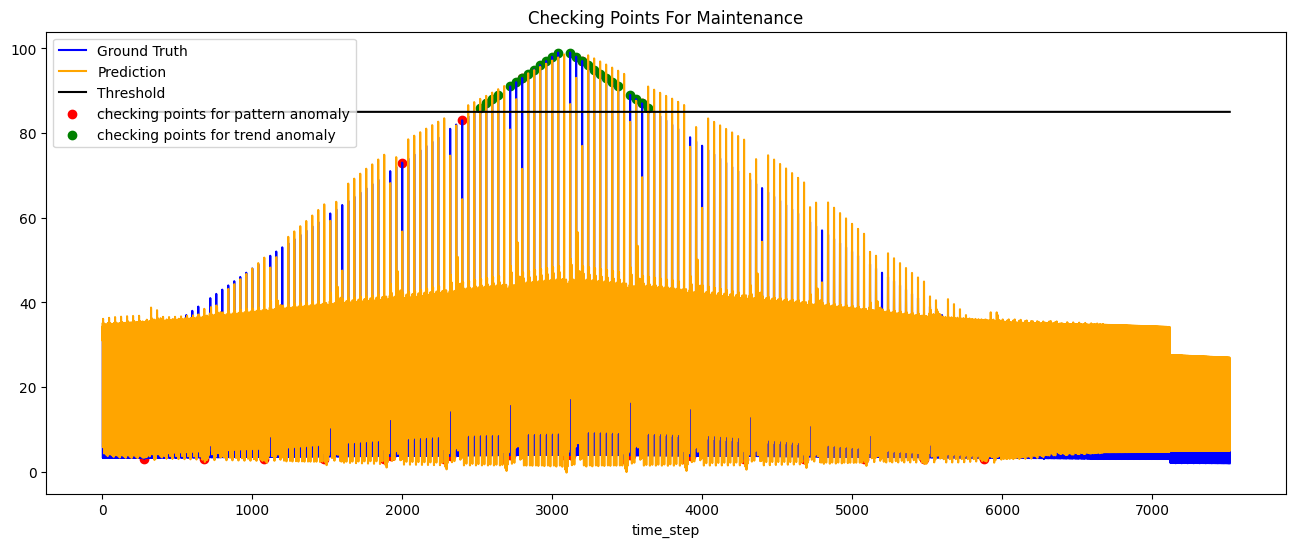

In [18]:
plot_anomalies_value(y_test_unscale, y_pred_test_unscale, test_anomaly_indexes['pattern anomaly index'], test_anomaly_indexes['trend anomaly index'], vibration_th)

Then, we can focus on these checking points to avoid asset loss in time.